In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [2]:
data = pd.read_excel('SP23_Cleaned Data.xlsx')

In [3]:
df = data.groupby('Date')[['Demand']].sum()

In [5]:
df.reset_index(inplace=True)

In [8]:
df.head(3).append(df.tail(3))

,Date,Demand
0,2023-02-06,1766
1,2023-02-07,1612
2,2023-02-08,1896
77,2023-05-24,2164
78,2023-05-25,1832
79,2023-05-26,2052


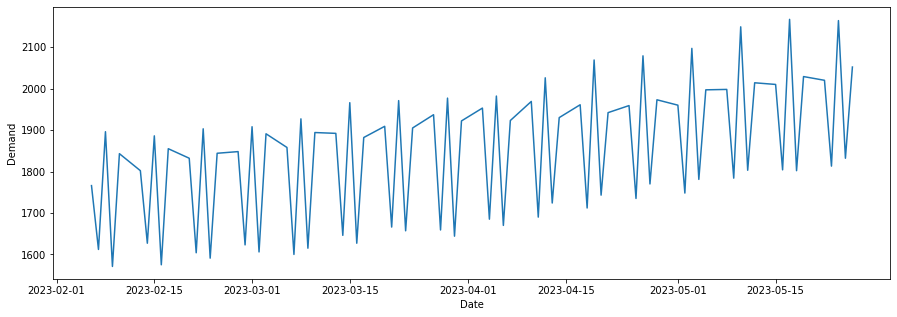

In [12]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Date', y='Demand', data=df)

plt.show()

In [15]:
ad_fuller_result = adfuller(df['Demand'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.3650700375590645
p-value: 0.9969495369837793


In [16]:
y_diff = np.diff(df['Demand'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.530120095125755
p-value: 9.918061162740372e-09


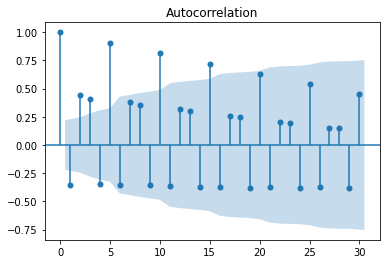

In [14]:
plot_acf(df['Demand'], lags=30);

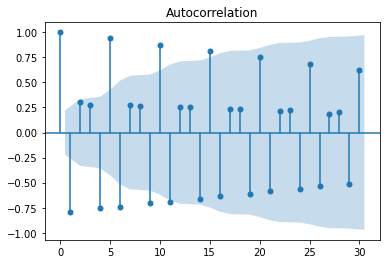

In [17]:
plot_acf(y_diff, lags=30);

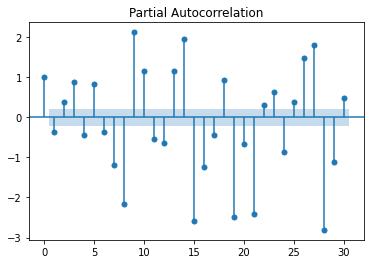

In [18]:
plot_pacf(df['Demand'], lags=30);

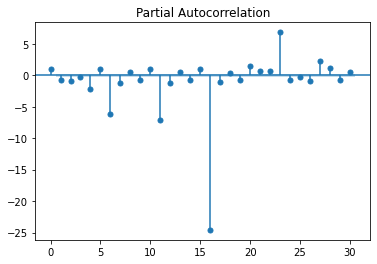

In [19]:
plot_pacf(y_diff, lags=30);

In [23]:
train = df[:-10]
test = df[-10:]

train.tail()

,Date,Demand
65,2023-05-08,1998
66,2023-05-09,1784
67,2023-05-10,2149
68,2023-05-11,1803
69,2023-05-12,2014


In [20]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 5

In [25]:
import warnings
warnings.filterwarnings('ignore')

SARIMA_result_df = optimize_SARIMA(train['Demand'], order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 0, 0)",552.355083
1,"(0, 1, 0, 0)",552.704628
2,"(1, 3, 0, 0)",552.777437
3,"(0, 2, 0, 0)",552.987487
4,"(2, 1, 0, 1)",553.051218


In [35]:
SARIMA_model = SARIMAX(train['Demand'], order=(0,1,1), seasonal_order=(0,1,0,5), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                   70
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 5)   Log Likelihood                -274.352
Date:                            Tue, 28 Feb 2023   AIC                            552.705
Time:                                    13:47:11   BIC                            557.022
Sample:                                         0   HQIC                           554.406
                                             - 70                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9492      0.080    -11.896      0.000      -1.106      -0.793
sigma2       298.3386     55.896   

In [36]:
SARIMA_pred = SARIMA_model_fit.get_prediction(70, 79).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test

,Date,Demand,SARIMA_pred
70,2023-05-15,2010,2017.972807
71,2023-05-16,1804,1803.972807
72,2023-05-17,2167,2168.972807
73,2023-05-18,1802,1822.972807
74,2023-05-19,2029,2033.972807
75,2023-05-22,2020,2037.945614
76,2023-05-23,1813,1823.945614
77,2023-05-24,2164,2188.945614
78,2023-05-25,1832,1842.945614
79,2023-05-26,2052,2053.945614


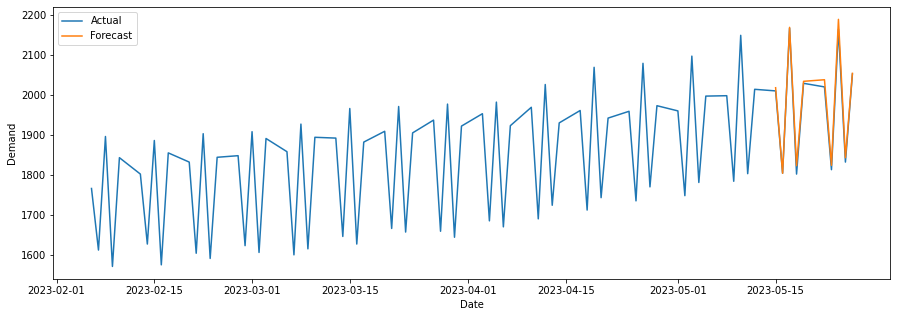

In [37]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Date', y='Demand', data=df, label='Actual')
sns.lineplot(x='Date', y='SARIMA_pred', data=test, label='Forecast')

plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

prophet_mae = mean_absolute_error(test['Demand'], test['SARIMA_pred'])
print(prophet_mae)

10.26464923358244
